In [2]:
using PyPlot
using HDF5,FFTW,FourierFlows
using LinearAlgebra: mul!, ldiv!
using Statistics
using PyCall,LazCh5
glob = pyimport("glob2")

┌ Info: FourierFlows will use 4 threads
└ @ FourierFlows /home/doraho/.julia/packages/FourierFlows/DtzuG/src/FourierFlows.jl:123


PyObject <module 'glob2' from '/usr/local/lib/python3.6/dist-packages/glob2/__init__.py'>

In [44]:
function Energydecomposition(B1,B2,B3;kf=[1,5],Lx = 2π)
    
    k1,k2 = minimum(kf),maximum(kf);
    nx,ny,nz = size(B1);
    T    = Float32;
    grid = ThreeDGrid(nx, Lx, T = T);
    
    B1h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B2h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B3h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    Bxhf = copy(B1h); 
    Byhf = copy(B2h);
    Bzhf = copy(B3h);
    mul!(B1h, grid.rfftplan, B1); 
    mul!(B2h, grid.rfftplan, B2); 
    mul!(B3h, grid.rfftplan, B3);
    
    
    for i in 1:div(nz,2)+1, j in 1:ny, k in 1:nx
       x,y,z = grid.kr[i],grid.l[j],grid.m[k];
       rr    = sqrt(x^2+y^2+z^2); 
       if (( rr >=  k1) && (rr <= k2))
           Bxhf[i,j,k] = B1h[i,j,k];
           Byhf[i,j,k] = B2h[i,j,k];
           Bzhf[i,j,k] = B3h[i,j,k];
       end
    end
    cB1,cB2,cB3 = zeros(T,size(B1)),zeros(T,size(B1)),zeros(T,size(B1));
    ldiv!(cB1, grid.rfftplan,Bxhf);  
    ldiv!(cB2, grid.rfftplan,Byhf);
    ldiv!(cB3, grid.rfftplan,Bzhf);
    return cB1,cB2,cB3;
end


function Curl(B1,B2,B3;Lx = 2π)
    #funtion of computing ∇×Vector using the fourier method
    # fft(∇×Vector) -> im * k × V
    #| i j k  |
    #| x y z  |
    #|B1 B2 B3|
    # (y*B3 - z*B2) i - (x*B3 - z*B1) j + (x*B2 - y*B1) k
    nx,ny,nz = size(B1);
    T    = Float32;
    grid = ThreeDGrid(nx, Lx, T = T);
    
    B1h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B2h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B3h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    cBxh = copy(B1h); 
    cByh = copy(B2h);
    cBzh = copy(B3h);
    mul!(B1h, grid.rfftplan, B1); 
    mul!(B2h, grid.rfftplan, B2); 
    mul!(B3h, grid.rfftplan, B3);
        
    for i in 1:div(nz,2)+1, j in 1:ny, k in 1:nx
       x,y,z = grid.kr[i],grid.l[j],grid.m[k]; 
       cBxh[i,j,k] = im*(y*B3h[i,j,k] - z*B2h[i,j,k]);
       cByh[i,j,k] = im*(z*B1h[i,j,k] - x*B3h[i,j,k]);
       cBzh[i,j,k] = im*(x*B2h[i,j,k] - y*B1h[i,j,k]);
    end
    
    cB1,cB2,cB3 = zeros(T,size(B1)),zeros(T,size(B1)),zeros(T,size(B1));
    ldiv!(cB1, grid.rfftplan, deepcopy(cBxh));  
    ldiv!(cB2, grid.rfftplan, deepcopy(cByh));
    ldiv!(cB3, grid.rfftplan, deepcopy(cBzh));
    return cB1,cB2,cB3;
end

function current_helicity(ib,jb,kb)
    #mean(j ⋅ b)
    dV = (2π/size(ib)[1])^3
    #B1,B2,B3 = Energydecomposition(ib,jb,kb;kf=[0,6.5]);
    b1,b2,b3 = Energydecomposition(ib,jb,kb;kf=[6.51,256]);
    j1,j2,j3 = Curl(b1,b2,b3;Lx = 2π)
    return mean(j1.*b1 .+ j2.*b2 .+ j3.*b3)
end

function kinetic_helicity(iv,jv,kv)
    #mean(v⋅ \omega)
    dV = (2π/size(iv)[1])^3
    #V1,V2,V3 = Energydecomposition(iv,jv,kv;kf=[0,6.5]);
    v1,v2,v3 = Energydecomposition(iv,jv,kv;kf=[6.51,256]);
    ω1,ω2,ω3 = Curl(v1,v2,v3;Lx = 2π)
    return mean(v1.*ω1 .+ v2.*ω2 .+ v3.*ω3)
end
function cross(A,B)
#=
cross product for two vector
    
    #| i j k  |
    #|A1 A2 A3|
    #|B1 B2 B3|
=#
    return (A[2]*B[3]-A[3]*B[2]),(A[3]*B[1]-A[1]*B[3]),(A[1]*B[2]-A[2]*B[1])
end

function cross(A1,A2,A3,B1,B2,B3)
#    cross product for two vector array
    return (A2.*B3.-A3.*B2),(A3.*B1.-A1.*B3),(A1.*B2.-A2.*B1)
end


function h_madvection(iv,jv,kv,ib,jb,kb,η)

    B1,B2,B3 = Energydecomposition(ib,jb,kb;kf=[0,6.5]);
    V1,V2,V3 = Energydecomposition(iv,jv,kv;kf=[0,6.5]);
    v1,v2,v3 = iv.-V1,jv.-V2,kv.-V3;
    b1,b2,b3 = ib.-B1,jb.-B2,kb.-B3;
    j1,j2,j3 = Curl(b1,b2,b3;Lx = 2π); # J = ∇ × B
    vcrossb_1,vcrossb_2,vcrossb_3 = cross(v1,v2,v3,b1,b2,b3); # mean( v × b )
    
        
    μ_V = [mean(V1),mean(V2),mean(V3)];
    μ_B = [mean(B1),mean(B2),mean(B3)];
    μ_b = [mean(b1),mean(b2),mean(b3)];
    μ_j = [mean(j1),mean(j2),mean(j3)];
    ε = [mean(vcrossb_1),mean(vcrossb_2),mean(vcrossb_3)];
    
           # -2 ε ⋅ mean(B) - 2 η ⋅ mean(j ⋅ b)
    return -2*(ε[1]*μ_B[1]+ε[2]*μ_B[2]+ε[3]*μ_B[3]) - 2*η*(μ_j[1]*μ_b[1]+μ_j[2]*μ_b[2]+μ_j[3]*μ_b[3]) 
end

h_madvection (generic function with 1 method)

In [48]:
ff = sort(glob.glob("/home/doraho/ResearchNoteboook/Simulation/Project_Spectral_Julia/*.h5"));
#ff = sort(glob.glob("/mnt/c/data/*.h5"));
ff;

In [131]:
ff = sort(glob.glob("/mnt/c/data/Aniso2/*.h5"))

200-element Array{String,1}:
 "/mnt/c/data/Aniso2/Spectral_Test_t_0001.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0002.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0003.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0004.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0005.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0006.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0007.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0008.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0009.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0010.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0011.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0012.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0013.h5"
 ⋮
 "/mnt/c/data/Aniso2/Spectral_Test_t_0189.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0190.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0191.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0192.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0193.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0194.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0195.h5"
 "/mnt/c/data/Aniso2/Spectral_Test_t_0196.h5"
 "

In [165]:
BBs_S = [];
BBs_L = [];
h_ms  = [];
h_ks  = [];
advecs = [];
meanB = [];
ibs = [];
dV = (π*2/256)^3
j=1;
for fs in ff[1:1:100]
    println(fs)
    f = h5open(fs,"r")
    iv = read( f , "i_velocity",  ) ;
    jv = read( f , "j_velocity",  ) ;
    kv = read( f , "k_velocity",  ) ;
    ib = read( f , "i_mag_field", ) ;
    jb = read( f , "j_mag_field", ) ;
    kb = read( f , "k_mag_field", ) ;
    push!(meanB,mean(ib))
    B1L,B2L,B3L = Energydecomposition(ib,jb,kb;kf=[0,7]);
    B1S,B2S,B3S = Energydecomposition(ib,jb,kb;kf=[19,42]);
    close(f)
    BBL = sum(B1L.^2 .+ B2L.^2 .+ B3L.^2)*dV;
    BBS = sum(B1S.^2 .+ B2S.^2 .+ B3S.^2)*dV;
    #advec   = h_madvection(iv,jv,kv,ib,jb,kb,η)
    #h_m,h_k = current_helicity(ib,jb,kb),kinetic_helicity(iv,jv,kv)
    push!(BBs_S,BBS);
    push!(BBs_L,BBL);
    #push!(advecs,advec)
    #push!(h_ms,h_m)
    #push!(h_ks,h_k)
    figure(figsize=(12,4))
    subplot(131)
    title("Large Scale Bₓ k∈[0,7]")
    plotM = B1L[:,:,1];
    imshow(plotM,cmap="RdBu",vmin=mean(plotM)-2*std(plotM),vmax=mean(plotM)+2*std(plotM))
    subplot(132)
    title("Small Scale Bₓ k∈[19,42]")
    plotM = B1S[:,:,1];
    imshow(plotM,cmap="RdBu",vmin=mean(plotM)-2*std(plotM),vmax=mean(plotM)+2*std(plotM))
    subplot(133)
    title("Bₓ")
    plotM = ib[:,:,1];
    imshow(plotM,cmap="RdBu",vmin=mean(plotM)-2*std(plotM),vmax=mean(plotM)+2*std(plotM))
    savefig("/mnt/c/data/Aniso2/GIF/$j.png")
    j+=1;
end

/mnt/c/data/Aniso2/Spectral_Test_t_0001.h5


LoadError: [91mInterruptException:[39m

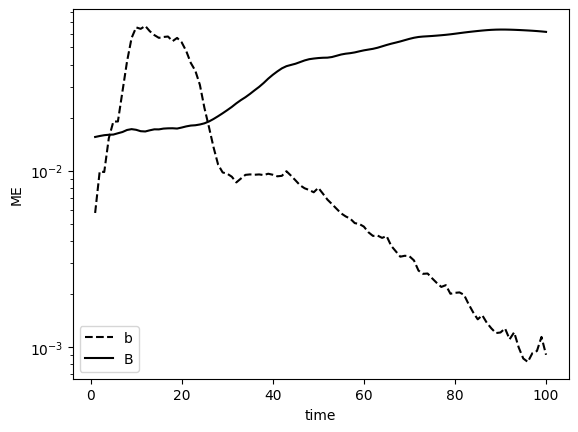

Any[]

In [162]:
dt = 1
t  = collect(1:dt:(length(BBs_S))*dt)
plot(t,BBs_S,"k--",label="b")
plot(t,BBs_L,"k",label="B")
ylabel("ME")
xlabel("time")
legend()
semilogy()

In [163]:
fs = ff[99]
println(fs)
f = h5open(fs,"r")
iv = read( f , "i_velocity",  ) ;
jv = read( f , "j_velocity",  ) ;
kv = read( f , "k_velocity",  ) ;
ib = read( f , "i_mag_field", ) ;
jb = read( f , "j_mag_field", ) ;
kb = read( f , "k_mag_field", ) ;

/mnt/c/data/Aniso2/Spectral_Test_t_0099.h5


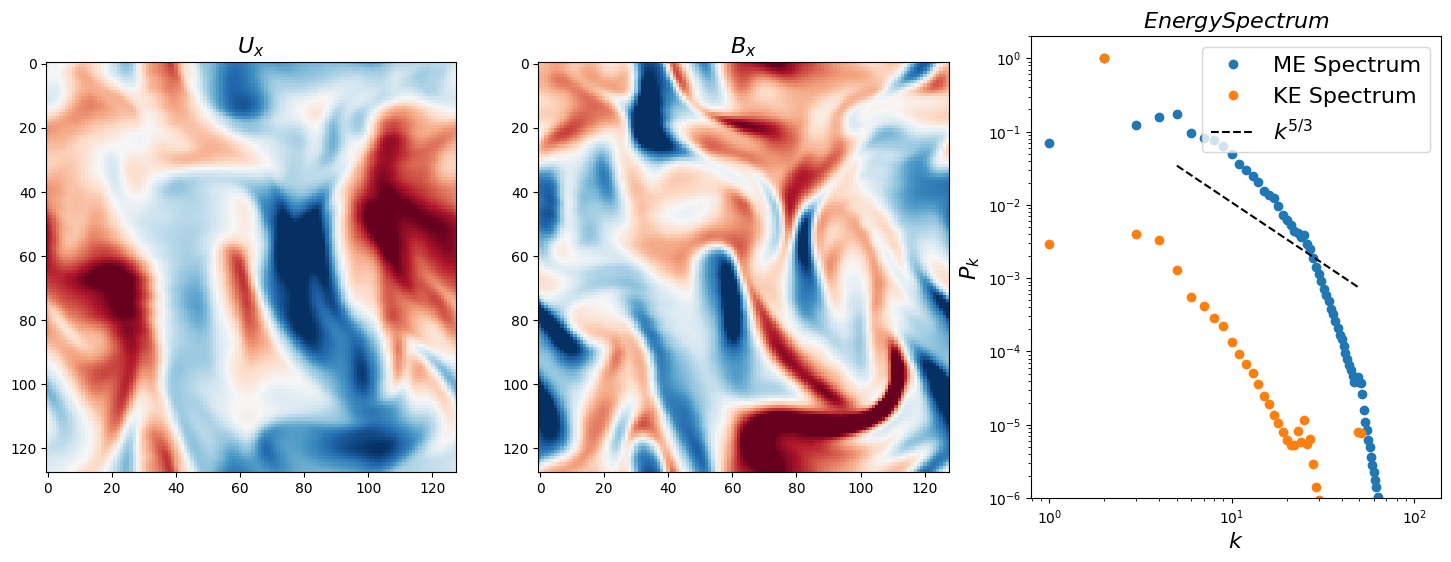

PyObject <matplotlib.legend.Legend object at 0x7f4f701945f8>

In [164]:
tot_KE =  iv.^2 .+ jv.^2 + kv.^2;
tot_ME =  ib.^2 .+ jb.^2 + kb.^2;

y_K,x = spectrallines3D(tot_KE);
y_M,x = spectrallines3D(tot_ME);

y_K /=maximum(y_K);
y_M /=maximum(y_M);

figure(figsize=(18,6))
subplot(131)
plotM = iv[:,:,1];
imshow(plotM,cmap="RdBu",vmin=mean(plotM)-2*std(plotM),vmax=mean(plotM)+2*std(plotM))
title(L"U_x",size=16)
subplot(132)
plotM = ib[:,:,1];
imshow(plotM,cmap="RdBu",vmin=mean(plotM)-2*std(plotM),vmax=mean(plotM)+2*std(plotM))
title(L"B_x",size=16)
subplot(133)
loglog(x,y_M,"o",label="ME Spectrum");
loglog(x,y_K,"o",label="KE Spectrum");
loglog(x[5:50],x[5:50].^(-5/3)/2,"k--",label=L"k^{5/3}")
ylabel(L"P_k}",size=16)
xlabel(L"k",size=16)
title(L"Energy Spectrum",size=16)
ylim(1e-6,2e0)
legend(fontsize=16)

In [25]:
function VectorPotential(B1,B2,B3)
#=   
    funtion of computing B = ∇ × A using the fourier method
     fft(∇×Vector) -> im * k × A
      | i j k  |
      | x y z  |  =  (y*A3 - z*A2) i - (x*A3 - z*A1) j + (x*A2 - y*A1) k
      |A1 A2 A3|
    
    Using the relations J = ∇ × (∇ × B) and ∇ ⋅ A = 0 in peroideric condition,
    we will arrive Jₖ = - kᵢ² Aₖ.
    
    Aₖ = (k × B)ᵢ/ kᵢ²   
    
=#
    nx,ny,nz = size(B1);
    T    = Float32;
    Lx=2π
    grid = ThreeDGrid(nx, Lx, T = T);
    
    B1h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B2h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    B3h = zeros(ComplexF32,(div(nx,2)+1,ny,nz));
    Axh = copy(B1h); 
    Ayh = copy(B2h);
    Azh = copy(B3h);
    mul!(B1h, grid.rfftplan, B1); 
    mul!(B2h, grid.rfftplan, B2); 
    mul!(B3h, grid.rfftplan, B3);
        
    for i in 1:div(nz,2)+1, j in 1:ny, k in 1:nx
       x,y,z = grid.kr[i],grid.l[j],grid.m[k]; 
       Axh[i,j,k] = im*(y*B3h[i,j,k] - z*B2h[i,j,k])/x^2;
       Ayh[i,j,k] = im*(z*B1h[i,j,k] - x*B3h[i,j,k])/y^2;
       Azh[i,j,k] = im*(x*B2h[i,j,k] - y*B1h[i,j,k])/z^2;
       Axh[i,j,k] = ifelse(x == 0, 0,  Axh[i,j,k]);
       Ayh[i,j,k] = ifelse(y == 0, 0,  Ayh[i,j,k]);
       Azh[i,j,k] = ifelse(z == 0, 0,  Azh[i,j,k]);
    end
    
    A1,A2,A3 = zeros(T,size(B1)),zeros(T,size(B1)),zeros(T,size(B1));
    ldiv!(A1, grid.rfftplan, deepcopy(Axh));  
    ldiv!(A2, grid.rfftplan, deepcopy(Ayh));
    ldiv!(A3, grid.rfftplan, deepcopy(Azh));
    return A1,A2,A3;
    
end

VectorPotential (generic function with 1 method)

In [26]:
@time A1,A2,A3 = VectorPotential(ib,jb,kb);

  6.513449 seconds (228.36 M allocations: 4.850 GiB, 7.78% gc time)


In [18]:
#j_h = mean_b*mean_ϕ + mean(a × (V × b)) + mean(a × (V × B)) -η mean(a × j)
# Δϕ = ∇ ⋅ (meanV × mean B + ε);
# ε = mean(v×b);

function j_h(V1,V2,V3,B1,B2,B3,η)
    v1 = V1-mean(V1);
    v2 = V2-mean(V2);
    v3 = V3-mean(V3);
    b1 = B1-mean(B1);
    b2 = B2-mean(B2);
    b3 = B3-mean(B3);
    μ_V = [mean(V1),mean(V2),mean(V3)];
    μ_B = [mean(B1),mean(B2),mean(B3)];
    μVcrossμB = cross(μ_V,μ_B); # mean(V)×mean(B)
    
    
end

function J_HS(V1,V2,V3,B1,B2,B3,η)
#J_HS = mean(BΦ) + mean(A)×(mean(V)×mean(B)+ε) - η(mean(A)×mean(J));

    A1,A2,A3 =  VectorPotential(B1,B2,B3);
    J1,J2,J3 =  Curl(B1,B2,B3;Lx = 2π); # J = ∇ × B
    
    μ_V = [mean(V1),mean(V2),mean(V3)];
    μ_B = [mean(B1),mean(B2),mean(B3)];
    μ_A = [mean(A1),mean(A2),mean(A3)];
    
    μVcrossμB = cross(μ_V,μ_B); # mean(V)×mean(B)
    μAcrossμJ = cross(μ_A,μ_J); # mean(V)×mean(B)
    
    
    v1 = V1-μ_V[1];
    v2 = V2-μ_V[2];
    v3 = V3-μ_V[3];
    b1 = B1-μ_V[1];
    b2 = B2-μ_V[2];
    b3 = B3-μ_V[3];
    vcrossb_1,vcrossb_2,vcrossb_3 = cross(v1,v2,v3,b1,b2,b3);
    ε = [mean(vcrossb_1),mean(vcrossb_2),mean(vcrossb_3)];
    
    
    
end
function cross(A,B)
#=
cross product for two vector
    
    #| i j k  |
    #|A1 A2 A3|
    #|B1 B2 B3|
=#
    return (A[2]*B[3]-A[3]*B[2]),(A[3]*B[1]-A[1]*B[3]),(A[1]*B[2]-A[2]*B[1])
end

function cross(A1,A2,A3,B1,B2,B3)
#    cross product for two vector array
    return (A2.*B3.-A3.*B2),(A3.*B1.-A1.*B3),(A1.*B2.-A2.*B1)
end

cross (generic function with 2 methods)

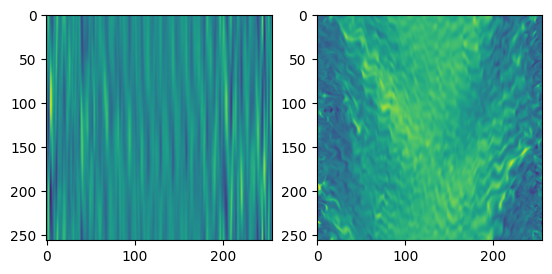

PyObject <matplotlib.image.AxesImage object at 0x7f4f82fa3438>

In [27]:
subplot(121)
imshow(A1[:,:,1])
subplot(122)
imshow(ib[:,:,1])